In [32]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import Word2Vec
import multiprocessing
import time
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim
from sklearn.model_selection import ParameterGrid


# **1. Data Collection & Preprocessing**

## **Corpus Selection**

I choose to do medical text summary containing over 14k entires. I wanted to choose a field that I am interested in and where I don't have much experience. I have never worked with medical data before so I thought this would be a good chance to do so.

In [33]:
df = pd.read_csv('bbc_data.csv')
text = df.iloc[:,0]
target = df.iloc[:,1]

## **Cleaning & Tokenization**

In [34]:
split = text.str.split(r'(?<=[.!?])\s+(?=[A-Z])', regex=True).explode()
full_text = pd.merge(split, target, left_index=True, right_index=True, how="left").reset_index(drop=True)
full_text

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,A singer hoping to perform in the US can expec...,entertainment
2,Groups including the Musicians Union are calli...,entertainment
3,US acts are not faced with comparable expense ...,entertainment
4,Nigel McCune from the Musicians Union said Bri...,entertainment
...,...,...
31976,"Security firm iDefence, which notified users o...",tech
31977,The problem affects all users of iTunes - Wind...,tech
31978,Users can automatically upgrade iTunes by open...,tech
31979,The security firm says users should avoid clic...,tech


In [35]:
full_text['data'] = full_text['data'].astype(str).apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
full_text['data'] = full_text['data'].str.lower().str.split(r'\W+', regex=True)
full_text

,data,labels
0,"[musicians, to, tackle, us, red, tape, musicia...",entertainment
1,"[a, singer, hoping, to, perform, in, the, us, ...",entertainment
2,"[groups, including, the, musicians, union, are...",entertainment
3,"[us, acts, are, not, faced, with, comparable, ...",entertainment
4,"[nigel, mccune, from, the, musicians, union, s...",entertainment
...,...,...
31976,"[security, firm, idefence, which, notified, us...",tech
31977,"[the, problem, affects, all, users, of, itunes...",tech
31978,"[users, can, automatically, upgrade, itunes, b...",tech
31979,"[the, security, firm, says, users, should, avo...",tech


In [36]:
sorted_text = full_text.sort_values(['data'], key=lambda x: x.apply(len), ascending=False)
trimmed_text = sorted_text[sorted_text['data'].apply(lambda x: 5 <= len(x) <= 45)]
trimmed_text

,data,labels
1996,"[the, comic, and, actor, said, he, had, drawn,...",entertainment
30667,"[bt, is, keen, to, provide, extra, services, t...",tech
11902,"[nobody, knows, exactly, how, many, iraqis, ar...",business
3829,"[stop, puting, it, all, in, brackets, and, let...",entertainment
28161,"[he, added, i, wouldnt, go, around, with, 666,...",tech
...,...,...
16265,"[ronaldo, 9, rooney, 87, 9033]",sport
14078,"[can, smith, work, scottish, wonders]",sport
14528,"[who, knows, what, might, happen]",sport
15455,"[subs, not, used, warrington, maloney]",sport


In [37]:
category_to_idx = {cat: idx for idx, cat in enumerate(trimmed_text['labels'].unique())}
trimmed_text.loc[:, 'label_idx'] = trimmed_text['labels'].map(category_to_idx)
trimmed_text

/var/folders/kd/8jptvn1s1c7dqlrnrwvj24100000gn/T/ipykernel_17550/3724665379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_text.loc[:, 'label_idx'] = trimmed_text['labels'].map(category_to_idx)


,data,labels,label_idx
1996,"[the, comic, and, actor, said, he, had, drawn,...",entertainment,0
30667,"[bt, is, keen, to, provide, extra, services, t...",tech,1
11902,"[nobody, knows, exactly, how, many, iraqis, ar...",business,2
3829,"[stop, puting, it, all, in, brackets, and, let...",entertainment,0
28161,"[he, added, i, wouldnt, go, around, with, 666,...",tech,1
...,...,...,...
16265,"[ronaldo, 9, rooney, 87, 9033]",sport,4
14078,"[can, smith, work, scottish, wonders]",sport,4
14528,"[who, knows, what, might, happen]",sport,4
15455,"[subs, not, used, warrington, maloney]",sport,4


In [38]:
vocab = set([word for row in trimmed_text['data'] for word in row])
len(vocab)

30843

The length of the vocabulary is: 30843


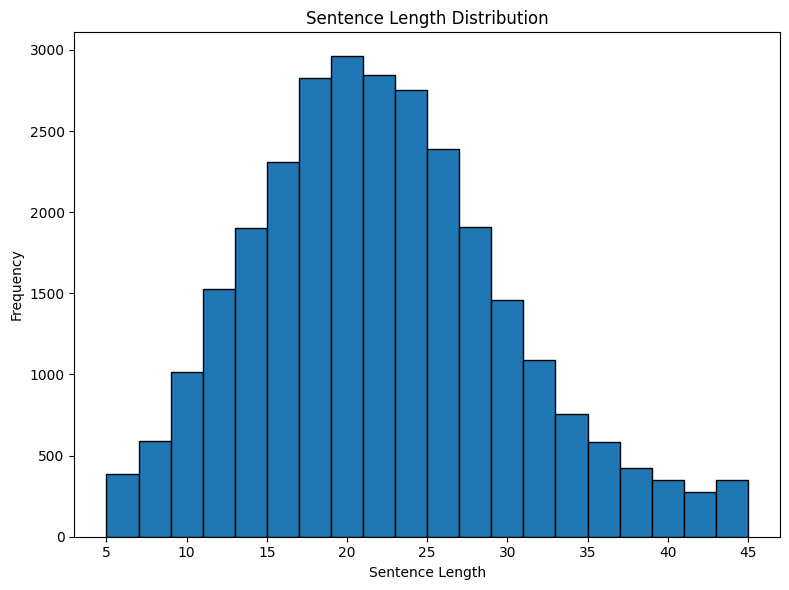

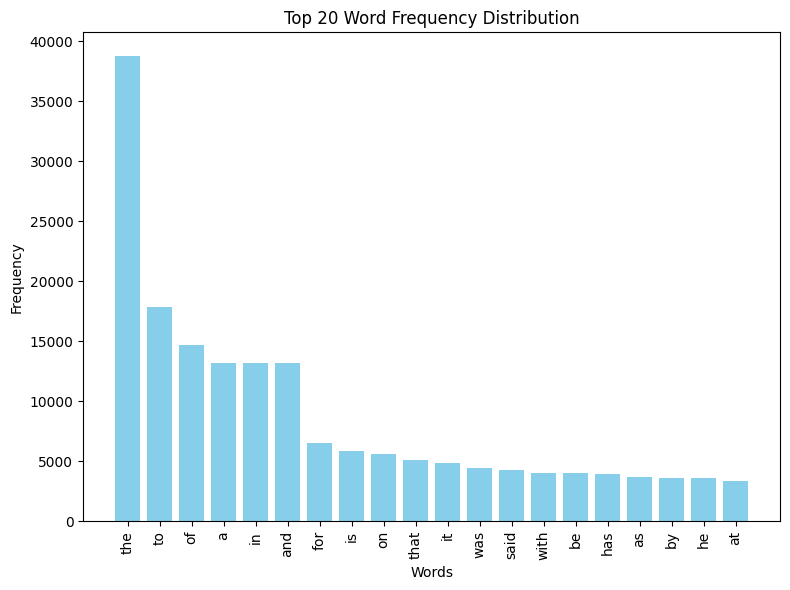

In [39]:
print('The length of the vocabulary is:', len(vocab))
word_counts = Counter(word for row in trimmed_text['data'] for word in row)

top_20 = word_counts.most_common(20)

words = [w for (w,c) in top_20]
counts = [c for (w,c) in top_20]

sentence_lengths = [len(s) for s in trimmed_text['data']]

plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=20, edgecolor='black')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.tight_layout()


plt.figure(figsize=(8, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequency Distribution')
plt.xticks(rotation=90)
plt.tight_layout()

I decided to make some judgement calls, I felt that leaving in stop words is important for medical text because they can really help describe what is happening. I also decided to trunkate some of the sentences in my corpus, because I had some extremel outliers, e.g. word one sentences and 2000 word sentences.

# **2. Word2Vec Model Training:**

### **CBOW**

In [40]:
workers = max(1, multiprocessing.cpu_count() - 1)

start_time = time.time()

model_CBOW = Word2Vec(
    sentences=trimmed_text['data'],
    sg=0,
    vector_size=100,
    window=5,
    min_count=1,
    workers=workers,
)

training_time = time.time() - start_time
vocab_size = len(model_CBOW.wv.index_to_key)

print(f"Model trained in {training_time:.2f} seconds")
print(f"Final vocabulary size: {vocab_size}")

Model trained in 1.03 seconds
Final vocabulary size: 30843


### **Skip-Gram**

In [41]:
workers = max(1, multiprocessing.cpu_count() - 1)

start_time = time.time()

model_SG = Word2Vec(
    sentences=trimmed_text['data'],
    sg=1,
    vector_size=100,
    window=5,
    min_count=1,
    workers=workers,
)

training_time = time.time() - start_time
vocab_size = len(model_SG.wv.index_to_key)

print(f"Model trained in {training_time:.2f} seconds")
print(f"Final vocabulary size: {vocab_size}")

Model trained in 2.75 seconds
Final vocabulary size: 30843


## **Hyperparameter Experiments**

In [42]:
word_to_idx = {word: i+1 for i, word in enumerate(model_CBOW.wv.index_to_key)}
word_to_idx['<PAD>'] = 0 

embedding_dim = model_CBOW.vector_size
embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
for word, idx in word_to_idx.items():
    if word != '<PAD>' and word in model_CBOW.wv:
        embedding_matrix[idx] = model_CBOW.wv[word]

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super().__init__()
        
        # Load pre-trained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            bidirectional=True, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # Embed the words
        embedded = self.embedding(text)
        
        # Pack padded sequence for LSTM
        packed = pack_padded_sequence(embedded, text_lengths.cpu(), 
                                     batch_first=True, enforce_sorted=False)
        
        # Pass through LSTM
        packed_output, (hidden, cell) = self.lstm(packed)
        
        # Concatenate the final forward and backward hidden states
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        # Final linear layer
        output = self.fc(hidden)
        
        return output

In [43]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Convert words to indices
        text = self.texts[idx]
        indexed_text = [self.word_to_idx.get(word, 0) for word in text]
        
        # Convert to tensor
        text_tensor = torch.tensor(indexed_text, dtype=torch.long)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)  # Using long for multi-class
        
        return text_tensor, label_tensor, len(indexed_text)

# Collate function for DataLoader
def collate_batch(batch):
    # Unpack the batch
    texts, labels, lengths = zip(*batch)
    
    # Get sequence lengths
    lengths = torch.tensor(lengths, dtype=torch.long)
    
    # Pad sequences in this batch
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    
    # Stack labels
    labels = torch.stack(labels)
    
    return padded_texts, labels, lengths

dataset = TextClassificationDataset(
    trimmed_text['data'].tolist(),
    trimmed_text['label_idx'].tolist(),
    word_to_idx
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    collate_fn=collate_batch
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=128, 
    shuffle=False,
    collate_fn=collate_batch
)

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 2

# Training function with a single tqdm bar
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total_samples = 0
    
    # Simple progress bar for batches
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for texts, labels, lengths in progress_bar:
        # Move to device
        texts = texts.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(texts, lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted_classes = torch.max(predictions, dim=1)
        correct = (predicted_classes == labels).sum().item()
        
        # Update metrics
        batch_loss = loss.item()
        batch_acc = correct / labels.size(0)
        epoch_loss += batch_loss * labels.size(0)
        epoch_acc += correct
        total_samples += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({"loss": f"{batch_loss:.4f}", "acc": f"{batch_acc:.4f}"})
    
    return epoch_loss / total_samples, epoch_acc / total_samples

# Evaluation function with a single tqdm bar
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc="Evaluating")
    
    with torch.no_grad():
        for texts, labels, lengths in progress_bar:
            # Move to device
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            predictions = model(texts, lengths)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Calculate accuracy
            _, predicted_classes = torch.max(predictions, dim=1)
            correct = (predicted_classes == labels).sum().item()
            
            # Update metrics
            batch_loss = loss.item()
            batch_acc = correct / labels.size(0)
            epoch_loss += batch_loss * labels.size(0)
            epoch_acc += correct
            total_samples += labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({"loss": f"{batch_loss:.4f}", "acc": f"{batch_acc:.4f}"})
    
    return epoch_loss / total_samples, epoch_acc / total_samples

In [45]:
w2v_params = {
    'sg': [0, 1],
    'vector_size': [100, 300],
    'window': [3, 5],
    'min_count': [1, 5],
    'negative': [3, 5],
    'hs': [0, 1]
}


EPOCHS = 2

best_val_acc = 0
best_val_loss = float('inf')
best_w2v_config = None
best_w2v_model = None
best_rnn_state = None

HIDDEN_DIM = 128
OUTPUT_DIM = len(category_to_idx)
NUM_LAYERS = 1
DROPOUT = 0.5
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
workers = max(1, multiprocessing.cpu_count() - 1)

# Total combinations for progress tracking
total_w2v_combinations = len(list(ParameterGrid(w2v_params)))
print(f"Starting hyperparameter search with {total_w2v_combinations} Word2Vec configurations")

# Start hyperparameter search
with tqdm(total=total_w2v_combinations, desc="Training Word2Vec models") as pbar:
    for w2v_config in ParameterGrid(w2v_params):
        # Train Word2Vec model with current configuration
        w2v_model = Word2Vec(
            sentences=trimmed_text['data'],
            vector_size=w2v_config['vector_size'],
            window=w2v_config['window'],
            min_count=w2v_config['min_count'],
            negative=w2v_config['negative'],
            hs=w2v_config['hs'],
            sg=w2v_config['sg'],
            workers=workers
        )
        word_to_idx = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}
        word_to_idx['<PAD>'] = 0 

        dataset = TextClassificationDataset(
            trimmed_text['data'].tolist(),
            trimmed_text['label_idx'].tolist(),
            word_to_idx
        )
        
        # Split the dataset
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # Create data loaders with the new datasets
        train_loader = DataLoader(
            train_dataset, 
            batch_size=32, 
            shuffle=True,
            collate_fn=collate_batch
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=128, 
            shuffle=False,
            collate_fn=collate_batch
        )
        
        # Get embedding dimension from the current Word2Vec model
        embedding_dim = w2v_model.vector_size
        
        # Create embedding matrix
        embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
        for word, idx in word_to_idx.items():
            if word != '<PAD>' and word in w2v_model.wv:
                embedding_matrix[idx] = w2v_model.wv[word]
        
        # Initialize RNN model with the correct dimensions
        model = RNNClassifier(
            vocab_size=len(word_to_idx),
            embedding_dim=embedding_dim,
            hidden_dim=HIDDEN_DIM,
            output_dim=OUTPUT_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Now load the pre-trained embeddings
        model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    
        current_best_val_loss = float('inf')
        
        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch+1}/{EPOCHS} - W2V config: {w2v_config}")
            start_time = time.time()
            
            # Training
            train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
            
            # Validation
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            
            # Track best model for current Word2Vec config
            if val_loss < current_best_val_loss:
                current_best_val_loss = val_loss
                current_model_state = model.state_dict().copy()
            
            # Track global best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_loss = val_loss
                best_w2v_config = w2v_config.copy()
                best_w2v_model = w2v_model
                best_rnn_state = model.state_dict().copy()
                
                # Save best models
                torch.save(model.state_dict(), 'best-rnn-model.pt')
                best_w2v_model.save('best-word2vec-model')
                
                print(f"New best model! Config: {best_w2v_config}")
                print(f"Val Acc: {best_val_acc*100:.2f}% | Val Loss: {best_val_loss:.4f}")
            
            end_time = time.time()
            epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        # Update progress bar
        pbar.update(1)

print("\n===============================================")
print("Hyperparameter search complete!")
print(f"Best Word2Vec configuration: {best_w2v_config}")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Best validation loss: {best_val_loss:.4f}")
print("Models saved as 'best-rnn-model.pt' and 'best-word2vec-model'")

Starting hyperparameter search with 64 Word2Vec configurations


Training Word2Vec models:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}
Val Acc: 83.03% | Val Loss: 0.4900

Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}
Val Acc: 87.47% | Val Loss: 0.3824

Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}
Val Acc: 87.91% | Val Loss: 0.3707

Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}
Val Acc: 88.15% | Val Loss: 0.3757

Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}
Val Acc: 88.43% | Val Loss: 0.3556

Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 0, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}
Val Acc: 89.20% | Val Loss: 0.3268

Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 0, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

New best model! Config: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}
Val Acc: 89.37% | Val Loss: 0.3360

Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 1, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 0, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 100, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 3}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2/2 - W2V config: {'hs': 1, 'min_count': 5, 'negative': 5, 'sg': 1, 'vector_size': 300, 'window': 5}


Training:   0%|          | 0/718 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Hyperparameter search complete!
Best Word2Vec configuration: {'hs': 1, 'min_count': 1, 'negative': 3, 'sg': 1, 'vector_size': 300, 'window': 5}
Best validation accuracy: 89.37%
Best validation loss: 0.3360
Models saved as 'best-rnn-model.pt' and 'best-word2vec-model'


Skip-gram predicts context words from the target word, which helps capture nuanced relationships important for classification. Using hierarchical softmax rather than negative sampling alone works well when you have a diverse vocabulary (common in news) and need precise representations of less frequent words. Since I had about 30,000 words this makes sense. A window of 5 words on either side balances local syntactic patterns with broader thematic information.

Since my downstream task was a classification task these hyperparamters make sense.

# **3. Intrinsic Evaluation of Embeddings:**

## **Similarity & Analogy Tasks**

In [55]:
model = Word2Vec.load('best-word2vec-model')

test_words = ["her", "confusion", "news"]
print("==== Word Similarities ====")

for word in test_words:
    if word in model.wv:
        print(f"\nWords similar to '{word}':")
    
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, score in similar_words:
            print(f"  {similar_word}: {score:.4f}")
    else:
        print(f"Word '{word}' not in vocabulary")

==== Word Similarities ====

Words similar to 'her':
  she: 0.6264
  prolong: 0.5851
  husband: 0.5702
  wta: 0.5581
  643m: 0.5433

Words similar to 'confusion':
  dignity: 0.7490
  examined: 0.7434
  applies: 0.7291
  icstis: 0.7227
  oversensitive: 0.7196

Words similar to 'news':
  website: 0.6426
  coleman: 0.6417
  investigates: 0.6390
  twos: 0.6388
  sequins: 0.6364


In [57]:
print("\n==== Word Analogies ====")
try:
    result = model.wv.most_similar(positive=['he', 'king'], negative=['car'], topn=1)
    print(f"he + king - queen = {result[0][0]} (score: {result[0][1]:.4f})")
except:
    print("Analogy failed - words may not be in vocabulary")


==== Word Analogies ====
he + king - queen = beggs (score: 0.5556)


In [59]:
words = ['man', 'woman', 'house']

valid_words = [word for word in words if word in model.wv.key_to_index]

word_vectors = [model.wv[word] for word in words]
    
avg_distances = []
dist_matrix = []

for i, word in enumerate(words):
        distances = []
        for j, other_word in enumerate(words):
                similarity = cosine_similarity(word_vectors[i].reshape(1, -1), word_vectors[j].reshape(1, -1))
                distances.append(similarity[0][0])
        dist_matrix.append(distances)

sim_df = pd.DataFrame(dist_matrix, index=words, columns=words)
sim_df


,man,woman,house
man,1.000000,0.427560,0.098323
woman,0.427560,1.000000,0.089067
house,0.098323,0.089067,1.000000


The relatively high similarity (0.427560) between "man" and "woman" indicates your model has correctly learned that these words are semantically related.

Object vs. Person distinction: Both "man" and "woman" have very low similarity scores with "house" (around 0.09), which demonstrates the model can distinguished between people and inanimate objects.

# **4. Visualization & Clustering:**

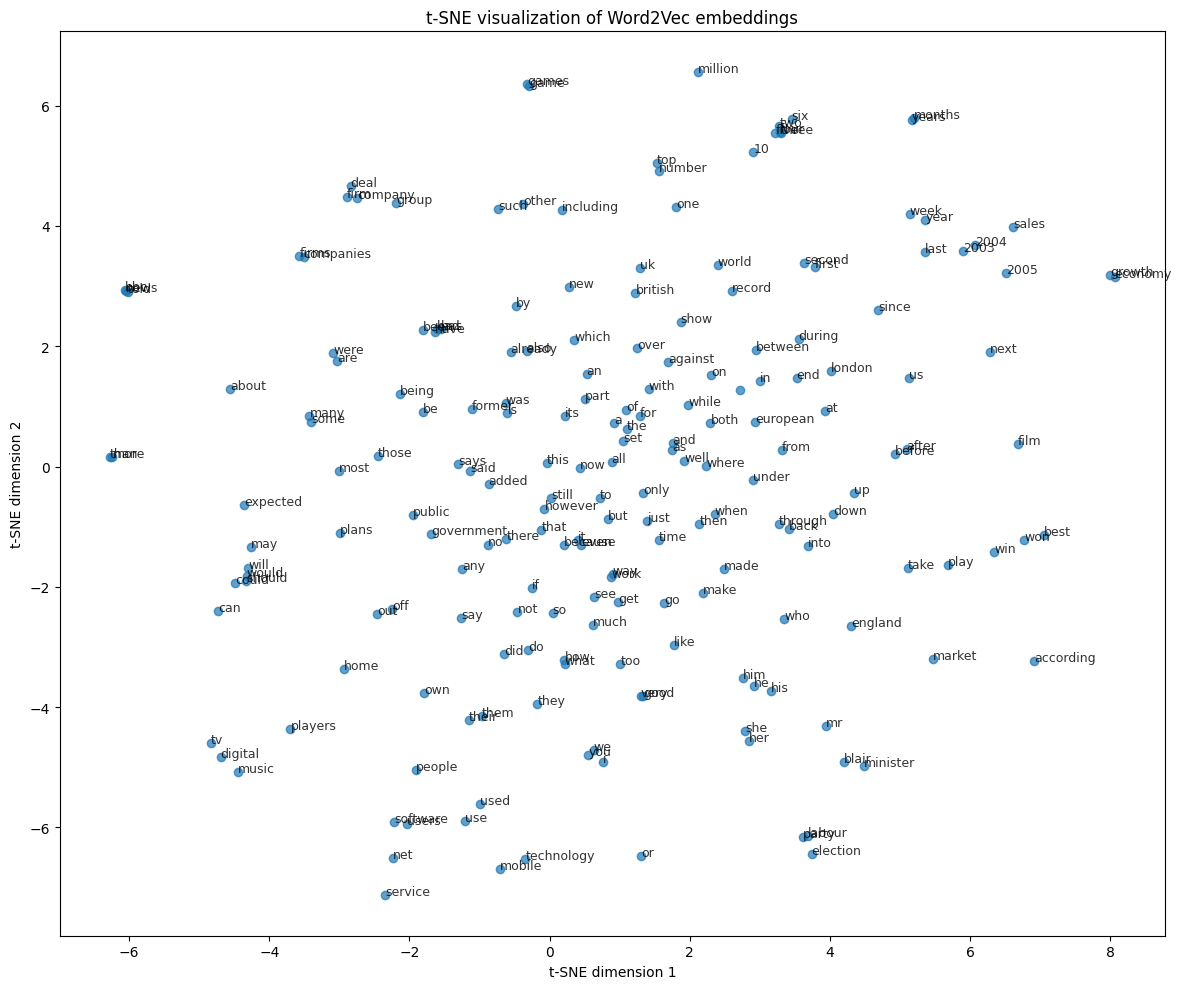

In [60]:
size = 200

words = [word for word, vocab in 
            sorted(model.wv.key_to_index.items(), 
                key=lambda item: model.wv.get_vecattr(item[0], "count"), 
                reverse=True)[:size]]

word_vectors = np.array([model.wv[word] for word in words])

tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(word_vectors)

df = pd.DataFrame({'x': tsne_results[:, 0], 
                    'y': tsne_results[:, 1], 
                    'word': words})

plt.figure(figsize=(12, 10))
plt.scatter(df['x'], df['y'], alpha=0.7)

for i, row in df.iterrows():
    plt.annotate(row['word'], (row['x'], row['y']), 
                fontsize=9, alpha=0.8)

plt.title(f"t-SNE visualization of Word2Vec embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.tight_layout()

When we exam the t-SNE plot we can see there are serval clusters that make sense. Top left is deal, company, group and top right we can see a cluster of years. However Since I did not take out stop words I think this model leaves much to be desired. 

# **5. Comparative Analysis & Reflection:**

Word2Vec creates a single vector per word, unable to capture multiple meanings. For example, "stick" (branch of a tree) and "stick" (to poke someone) share the same vector despite different contexts. There is also the problem that any words not seen during training have no vectors. In the news there are a lot of nouns that my Word2Vec model would not be able to vectorize.

For me since I kept stop words. Vectors may be unduly influenced by high-frequency words with limited semantic value and I think I potentially reduced semantic precision for content words.

**Improvements**

I would next retrain without the use of stopwords, I think a hybrid approach with BERT and Word2Vec would be the best, in that we could use BERT to get contextual embeddings. Another approach would be to give Word2Vec some attension so there can be weights on different context words in the sentence.